# Vehicle Detection

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip, ImageSequenceClip

%matplotlib inline
import matplotlib.pyplot as plt

## Load Images

In [2]:
TRAIN_IMAGES_DIR = "train_images"
NON_VEHICLES_DIRNAME = "non-vehicles"
VEHICLES_DIRNAME = "vehicles"
NON_VEHICLES_DIR = os.path.join(TRAIN_IMAGES_DIR, NON_VEHICLES_DIRNAME)
VEHICLES_DIR = os.path.join(TRAIN_IMAGES_DIR, VEHICLES_DIRNAME)
TEST_IMAGES_DIR = "test_images"

non_vehicle_images = []
for image_name in os.listdir(NON_VEHICLES_DIR):
    img = cv2.imread(os.path.join(NON_VEHICLES_DIR, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_vehicle_images.append(img)
vehicle_images = []
for image_name in os.listdir(VEHICLES_DIR):
    img = cv2.imread(os.path.join(VEHICLES_DIR, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vehicle_images.append(img)
test_images = []
for image_name in os.listdir(TEST_IMAGES_DIR):
    img = cv2.imread(os.path.join(TEST_IMAGES_DIR, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)

### Examples of Loaded Images

Non-Vehicle Training Image


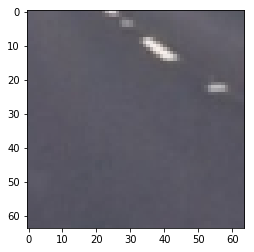

Vehicle Training Image


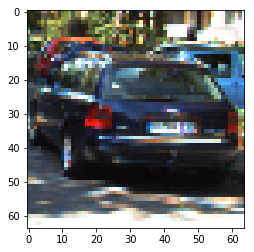

In [3]:
print("Non-Vehicle Training Image")
plt.imshow(non_vehicle_images[0])
plt.show()
print("Vehicle Training Image")
plt.imshow(vehicle_images[1])
plt.show()

Test Image


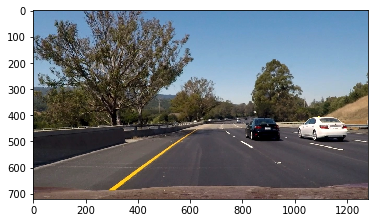

In [4]:
print("Test Image")
plt.imshow(test_images[0])
plt.show()

### Image Means

In [5]:
print("Non-Vehicle Training Image Mean:", np.mean(non_vehicle_images))
print("Vehicle Training Image Mean:", np.mean(vehicle_images))
print("Full Example Image Mean:", np.mean(test_images))

Non-Vehicle Training Image Mean: 85.19563170497416
Vehicle Training Image Mean: 75.84435653521646
Full Example Image Mean: 111.80363257137346


## HOG

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Compute HOG feature vector from an image. """
    result = hog(
        img, 
        orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        block_norm='L2-Hys',
        transform_sqrt=False, 
        visualise=vis, 
        feature_vector=feature_vec)
    return result

### Example Image HOG Visualization

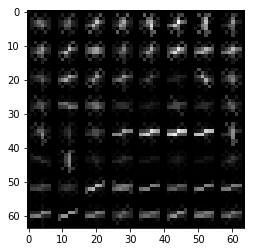

In [7]:
img_gray = cv2.cvtColor(vehicle_images[1].astype(np.uint8), cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(img_gray, 9, 8, 2, True, False)
plt.imshow(hog_image, cmap='gray')
plt.show()

## Color Histogram

In [8]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Compute color histogram feature vector from an image. """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

## Spatial Binning

In [9]:
def bin_spatial(img, size=(32, 32)):
    """Compute spatial bin feature map from an image. """
    features = cv2.resize(img, size).ravel()
    return features

## Combine Features

In [10]:
def extract_features(imgs, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block):
    """Combine spatial binning, histogram, and HOG features into a single vector. """
    features = []
    for image in imgs:
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0, 256))
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(
                feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        features.append(np.concatenate([spatial_features, hist_features]+hog_features))
    return features

## SVM Classifier Training

In [11]:
# Feature extraction parameters. 
spatial_size = (8, 8)
hist_bins = 32
orient = 11
pix_per_cell = 16
cell_per_block = 4

# Perform feature extraction. 
car_features = extract_features(vehicle_images, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
notcar_features = extract_features(non_vehicle_images, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)

# Create an array stack of feature vectors. 
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector. 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)
    
# Fit a per-column scaler only on the training data. 
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:', spatial_size,'and', hist_bins, 'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using spatial binning of: (8, 8) and 32 histogram bins
Feature vector length: 816
Test Accuracy of SVC =  0.9921


In [12]:
# Re-train on the entire dataset, with flip augmentation. 
vehicle_images_flipped = np.flip(vehicle_images, axis=2)
non_vehicle_images_flipped = np.flip(non_vehicle_images, axis=2)
car_flipped_features = extract_features(
    vehicle_images_flipped, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
notcar_flipped_features = extract_features(
    non_vehicle_images_flipped, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
X_augmented = np.vstack((car_features, notcar_features, car_flipped_features, notcar_flipped_features)).astype(np.float64)
y_augmented = np.concatenate([y, y], axis=0)
X_augmented, y_augmented = shuffle(X_augmented, y_augmented)

# Fit a per-column scaler only on the training data. 
X_scaler = StandardScaler().fit(X_augmented)
# Apply the scaler to X_train and X_test
X_augmented = X_scaler.transform(X_augmented)

svc.fit(X_augmented, y_augmented)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Draw Bounding Boxes

In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Create a new image with bounding boxes superimposed. """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    return imcopy

## Generate List of Windows

In [14]:
def find_windows(img, x_start, y_start, x_stop, y_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Create a list of windows with given size, overlap, and start/stop. """
    
    # Compute the span of the region to be searched.
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y.
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x and y.
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to. 
    window_list = []
    
    # Loop through all possible combinations of x and y positions. 
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position. 
            startx = xs*nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start
            endy = starty + xy_window[1]
            
            # Append window position to list. 
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows. 
    return window_list

## Create list of windows. 

Image Height: 720


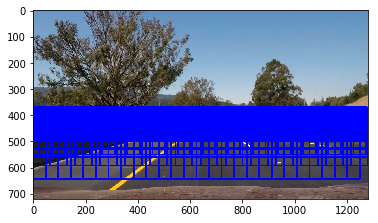

In [15]:
image = test_images[0]
image_height = image.shape[0]
print("Image Height:", image_height)
window_list = []
window_list += find_windows(image, 0, 370, 1280, 500, xy_window=(64, 64), xy_overlap=(0.9, 0.9))
window_list += find_windows(image, 0, 430, 1280, 550, xy_window=(96, 96), xy_overlap=(0.75, 0.75))
window_list += find_windows(image, 0, 400, 1280, 600, xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_list += find_windows(image, 0, 450, 1280, 650, xy_window=(192, 192), xy_overlap=(0.75, 0.75))
image_with_boxes = draw_boxes(image, window_list)
plt.imshow(image_with_boxes)
plt.show()

## Sliding Window Classification

In [16]:
def predict_image(image, classifier):
    """Run the classifier on a single cropped image. """
    standard_size=(64, 64)
    if image.shape != standard_size:
        image = cv2.resize(image, standard_size)
    [features] = extract_features([image], spatial_size, hist_bins, orient, pix_per_cell, cell_per_block)
    [scaled_features] = X_scaler.transform([features])
    [pred] = svc.predict([scaled_features])
    return pred

In [17]:
def sliding_window_search(image, classifier):
    """Find all boxes that are classified as 'vehicle'. """
    standard_size=(64, 64)
    bboxes = []
    for window in window_list:
        resized_image = image[window[0][1]:window[1][1], window[0][0]:window[1][0], :]
        pred = predict_image(resized_image, classifier)
        if pred>0.5:
            bboxes.append(window)
    return bboxes

## Heat Map

In [18]:
def add_heat(heatmap, bbox_list):
    """Start out with a blank (zeros) heatmap and add '1' to any pixel inside a box. """
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

In [19]:
def apply_threshold(heatmap, threshold):
    """Zero out any pixel that is below the threshold. """
    heatmap[heatmap <= threshold] = 0
    return heatmap

## Image Processing Pipeline

In [20]:
# Number of overlapping boxes needed to signal a positive result. 
DETECTION_THRESHOLD = 50
# "Bonus" given to pixels in the vicinity of vehicles identified in the previous frame. 
STARTING_HEATMAP_STRENGTH = 40
# Increase the size of detected boxes when giving a bonus to pixels in the next frame. 
INC = 10

In [21]:
def find_labeled_bboxes(labels):
    """Convert scipy labels to bboxes. """
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value. 
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels. 
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y. 
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Add the bbox to the list. 
        bboxes.append(bbox)
    return bboxes

In [22]:
def make_accumulated_heatmap(heatmap_dims, labeled_bboxes):
    """Give a large bonus to identified regions in the next frame's heatmap. """
    accumulated_heatmap = np.zeros(heatmap_dims, np.int32)
    increased_bboxes = []
    for bbox in labeled_bboxes:
        increased_bbox = ((bbox[0][0]-INC, bbox[0][1]-INC), (bbox[1][0]+INC, bbox[1][1]+INC))
        increased_bboxes.append(increased_bbox)
    accumulated_heatmap = add_heat(accumulated_heatmap, increased_bboxes)
    accumulated_heatmap = np.minimum(accumulated_heatmap, 1)*STARTING_HEATMAP_STRENGTH
    return accumulated_heatmap

In [23]:
def process_image(image, starting_heatmap=None, detection_threshold=DETECTION_THRESHOLD):
    """Process a single image, or one frame of a video. """
    if starting_heatmap is None:
        starting_heatmap = np.zeros([image.shape[0], image.shape[1]], np.int32)
    bbox_list = sliding_window_search(image, svc)
    heatmap = add_heat(starting_heatmap, bbox_list)
    heatmap = apply_threshold(heatmap, detection_threshold)
    labels = label(heatmap)
    labeled_bboxes = find_labeled_bboxes(labels)
    labeled_image = draw_boxes(image, labeled_bboxes)
    bbox_image = draw_boxes(image, bbox_list)
    accumulated_heatmap = make_accumulated_heatmap([image.shape[0], image.shape[1]], labeled_bboxes)
    return labeled_image, bbox_image, heatmap, accumulated_heatmap

## Detection on Single Images

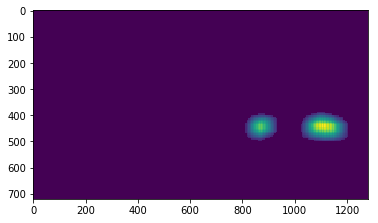

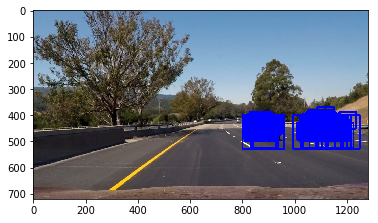

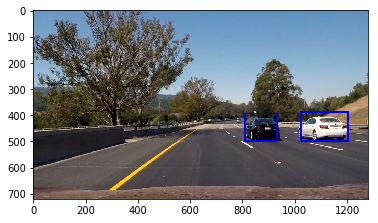

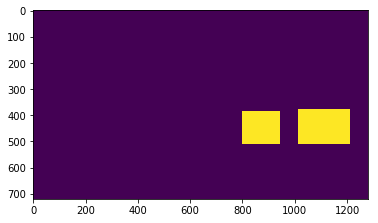

In [ ]:
labeled_images = []
bbox_images = []
heatmaps = []
accumulated_heatmaps = []
for i in range(len(test_images)):
    labeled_image, bbox_image, heatmap, accumulated_heatmap = process_image(
        test_images[i], 
        detection_threshold=DETECTION_THRESHOLD-STARTING_HEATMAP_STRENGTH)
    plt.imsave("output_images/labeled{}.png".format(i), labeled_image)
    plt.imsave("output_images/bbox{}.png".format(i), bbox_image)
    plt.imsave("output_images/heatmap{}.png".format(i), heatmap)
    plt.imsave("output_images/accumulated{}.png".format(i), accumulated_heatmap)
    labeled_images.append(labeled_image)
    bbox_images.append(bbox_image)
    heatmaps.append(heatmap)
    accumulated_heatmaps.append(accumulated_heatmap)
plt.imshow(heatmaps[0])
plt.show()
plt.imshow(bbox_images[0])
plt.show()
plt.imshow(labeled_images[0])
plt.show()
plt.imshow(accumulated_heatmaps[0])
plt.show()

## Video Processing

In [ ]:
base_video_name = "project_video"
input_video_name = base_video_name + ".mp4"
bbox_video_name = base_video_name + "_bbox.mp4"
output_video_name = base_video_name + "_output.mp4"
input_video = VideoFileClip(input_video_name)
input_frames = input_video.iter_frames()
output_frames = []
bbox_frames = []
accumulated_heatmap = None
for input_frame in input_frames:
    output_frame, bbox_frame, heatmap, accumulated_heatmap = process_image(input_frame, accumulated_heatmap)
    output_frames.append(output_frame)
    bbox_frames.append(bbox_frame)
output_video = ImageSequenceClip(output_frames, fps=input_video.fps)
output_video.write_videofile(output_video_name, audio=False)
output_video = ImageSequenceClip(bbox_frames, fps=input_video.fps)
output_video.write_videofile(bbox_video_name, audio=False)